# Tarea 4

Cuentas con un set de datos de imágenes en blanco y negro (de 28x28 pixeles) de distintas prendas de vestir (son 10 tipos de prendas en total, mira [aca](https://github.com/zalandoresearch/fashion-mnist)). En esta tarea vas a resolver el problema de crear nuevas imágenes prendas de vestir. Especificamente, la tarea que se te ha encomendado es:

> Elige dos tipos de los 10 tipos de prendas
>>Para cada uno de esos dos tipos, escribe una función que retorne uno de esos dos tipos, y retorne una nueva imagen de ese tipo, obtenida al azar, que no esté ya en el dataset

La solución a trabajar para escribir esta funcion consta de las siguientes partes

### Parte 1: datos, reducción de dimensionalidad

- Prueba dos formas de reducir a 6 dimensiones: PCA y autoencoders. 
- Busca 3 imágenes en el dataset. Para esas tres imágenes, compara visualmente lo que ocurre al (1) graficar la imagen original (hay código para eso más abajo) y (2) tomar el vector de la imagen, codificarlo, decodificarlo y volver a graficar (para pca y autoencoder, recuerda estandarizar y luego des-estandarizar, como hicimos en el notebook de compresión de la semana 9). 
- Sigue afinando tu método de reducción hasta que entregue imágenes que al codificar/decodificar, la imagen nueva resultante todavía guarde alguna semejanza con la realidad. 
- Una vez que estés satisfecho, transforma todo el dataset con tu método de reducción. Al dataset resultante (ahora con 6 dimensiones) le llamaremos **Xreducido**

### Parte 2: clustering y sampling 

- Ejecuta un algoritmo de clustering GMM sobre **Xreducido**, con 10 clústeres. Averigua como obtener las medias y las covarianzas de los 10 clústeres resultantes. 
- Usa *np.random.multivariate_normal(mean_vector,covariance_matrix)*, que se usa para obtener un elemento de la normal multivariada con su vector de media *mean_vector* y matriz de covarianzas *covariance_matrix*, para obtener un muestra de cada una de las 10 gaussianas que entrenó tu GMM. Esos muestras son elementos que podrían pertenecer a cada uno de los clústeres detectados por tu GMM. 

### Parte 3: análisis  

- Cada muestra puede ser graficado como imagen: hay que pasarlo por el decodificador (o la transformada inversa en el caso de PCA). 
- Analiza visualmente dos muestras de cada clase
- Analiza visualmente la media de cada cluster identificado por GMM
- Con las visualizaciones de esta parte, responde: ¿qué clústeres parece entregar consistentemente prendas de un tipo en específico? ¿qué prendas son?
- Entrena un clasificador de randomforest con los datos originales. 
- Samplea y decodifica 50 ejemplos de cada cluster identificado por GMM, y entrégaselos al randomforest. Ahora ve los resultados de las predicciones. Vé si son consistentes en el sentido de que predicen que una buena cantidad de los ejemplos de los dos clústeres que identificaste son de una prenda en particular. 

### Detalles académicos

La entrega de esta tarea es el Viernes 8 de Noviembre, a las 20:00, por canvas. 

## Datos

In [37]:
# Esta celda se demora 24 segundos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


import numpy as np
from tensorflow import keras

Bajamos el dataset, nos quedamos con 10.000 tuplas (esto es opcional, para que todo cargue más rápido, mientras más tuplas se dejen, mejor deberían ser los resultados)

In [2]:
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=True)
mnist.keys()

X, y = mnist['data'], mnist['target']
X_sample = X[60000:]
y_sample = y[60000:]
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 60000 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 59.8 MB


### Mostrando una foto
Para mostrar las fotos, tenemos que volver a formato de 28x28 píxeles

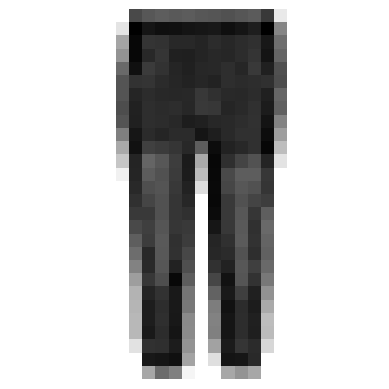

In [3]:
#sacar la entidad numero 2000 del dataset 

some_garment = X_sample.iloc[3000]
some_garment_image = some_garment.values.reshape(28,28)

plt.imshow(some_garment_image, cmap='binary')
plt.axis('off')
plt.show()

<div style="text-align: center;">
    <a href="https://ibb.co/LJH3RQ9">
        <img src="https://i.ibb.co/WPjL5DB/Designer.png" alt="Designer" border="0">
    </a>
</div>

# Parte 1: reducir dimensionalidad
¡Recuerda estandarizar los datos!

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=23)

In [5]:
# Estanadarizando X_sample

sc = StandardScaler()
X_std = sc.fit_transform(X_sample)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
indices = [0, 1, 2]  # Cambia estos índices según tus datos
imagenes_originales = X_std[indices]
# Des-estandarizar para visualizar
imagenes_desestandarizadas = sc.inverse_transform(imagenes_originales)

Autoencoders

In [7]:
num_dimensiones = X_std.shape[1]
encoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[num_dimensiones]),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(num_dimensiones, input_shape=[5]),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=0.1))

history = autoencoder.fit(X_std, X_std, epochs=100, validation_data=(X_std, X_std),
                          callbacks=[keras.callbacks.EarlyStopping(patience=10)])

X_encoded = encoder.predict(X_std[indices])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-28 21:15:14.771777: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


Epoch 1/100
287/313 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.9519

2024-10-28 21:15:15.427316: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2024-10-28 21:15:15.447595: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9418 - val_loss: 0.6278
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6111 - val_loss: 0.5602
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5672 - val_loss: 0.5138
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5026 - val_loss: 0.4955
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4871 - val_loss: 0.4919
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4782 - val_loss: 0.4912
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4825 - val_loss: 0.4909
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5108 - val_loss: 0.4905
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5184 - val_loss: 0.4905
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4810 - val_loss: 0.4904
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4799 - val_loss: 0.4901
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [8]:
# Codificar y decodificar las imágenes seleccionadas
X_encoded = encoder.predict(X_std[indices]) 
# Decodificar usando el decoder
X_decoded = decoder.predict(X_encoded)  
# Des-estandarizar
imagenes_decodificadas = sc.inverse_transform(X_decoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


PCA

In [9]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_std)
scaler_pca = StandardScaler()
scaler_pca.fit(X_pca)  # Ajustar el scaler a los datos PCA

# Des-estandarizar las imágenes PCA
imagenes_pca = scaler_pca.inverse_transform(X_pca)

Comparación

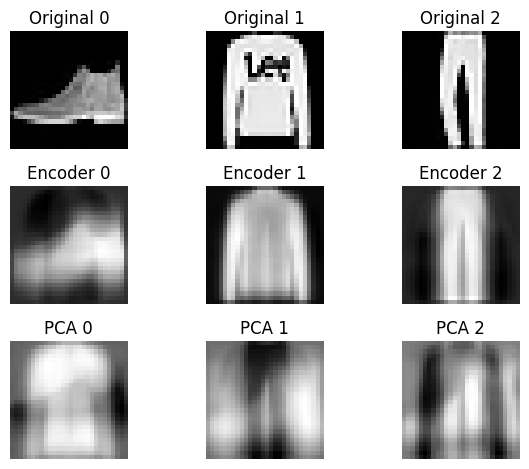

In [10]:
# Imágenes originales
for i in range(len(indices)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imagenes_desestandarizadas[i].reshape(28, 28), cmap='gray')  # Ajusta según la forma de tus imágenes
    plt.title('Original ' + str(indices[i]))
    plt.axis('off')

# Imágenes decodificadas del autoencoder
for i in range(len(indices)):
    plt.subplot(3, 3, i + 4)
    plt.imshow(imagenes_decodificadas[i].reshape(28, 28), cmap='gray')  # Ajusta según la forma de tus imágenes
    plt.title('Encoder ' + str(indices[i]))
    plt.axis('off')

for i in range(len(indices)):
    plt.subplot(3, 3, i + 7)
    plt.imshow(pca.components_[i].reshape(28, 28), cmap='gray')  # Reshape a 28x28
    plt.title('PCA ' + str(indices[i]))
    plt.axis('off')


plt.tight_layout()
plt.show()

Finalmente: ¿Con qué estrategia para reducir dimensionalidad te quedas? Transforma *X_sample* a *X_reducido*

**Respuesta:** Me quedaría con Encoder, porque PCA las imagenes no se ven correctamente. Encoder se parece pero pixeliado.

In [11]:

# Estandarizando X_sample
sc = StandardScaler()
X_std = sc.fit_transform(X_sample)

num_dimensiones = X_std.shape[1]

# Definición del encoder con Dropout
encoder = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[num_dimensiones]),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation='relu'),
])

# Definición del decoder
decoder = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[5]),
    keras.layers.Dense(num_dimensiones, activation='sigmoid'),
])

# Definición del autoencoder
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01))

# Entrenamiento del autoencoder
history = autoencoder.fit(X_std, X_std, epochs=200, validation_data=(X_std, X_std),
                          callbacks=[keras.callbacks.EarlyStopping(patience=10)])

# Transformación del dataset
X_reducido = encoder.predict(X_std)

Epoch 1/200


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-28 21:16:19.135749: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2024-10-28 21:16:19.146757: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8653 - val_loss: 0.7699
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7645 - val_loss: 0.7483
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7745 - val_loss: 0.7365
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7824 - val_loss: 0.7300
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7793 - val_loss: 0.7257
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7500 - val_loss: 0.7229
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7615 - val_loss: 0.7223
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7418 - val_loss: 0.7199
Epoch 9/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7354 - val_loss: 0.7201
Epoch 10/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7465 - val_loss: 0.7164
Epoch 11/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7542 - val_loss: 0.7156
Epoch 12/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

# Parte 2: Sampleo

Hacer fit de un modelo GMM

In [12]:
# Ejecuta un algoritmo de clustering GMM sobre **Xreducido**, con 10 clústeres. Averigua como obtener las medias y las covarianzas de los 10 clústeres resultantes.
mod_gmm = GaussianMixture(n_components=10, random_state=69)

mod_gmm.fit(X_reducido)

GaussianMixture(n_components=10, random_state=69)

In [13]:
# Obtener las medias de los clústeres
medias = mod_gmm.means_
# Obtener las covarianzas de los clústeres
covarianzas = mod_gmm.covariances_

In [14]:
print("La media promedio de los clusters será:")
for i in range(10):
    print(f"{i + 1}: {np.mean(medias[i])}")

La media promedio de los clusters será:
1: 40.64196928687945
2: 14.698344444158177
3: 4.03837671050615
4: 34.78404119302344
5: 17.178799272507508
6: 19.701413527913143
7: 20.419314647580784
8: 4.366326358099046
9: 34.75530087924916
10: 26.48373013475026


In [15]:
print("La covarianza promedio de los clusters será:")
for i in range(10):
    print(f"{i + 1}: {np.mean(covarianzas[i])}")

La covarianza promedio de los clusters será:
1: 308.719196218435
2: 94.09246433096509
3: 36.09866788910885
4: 263.568443679977
5: 89.74551836433689
6: 190.81579122379023
7: 203.11001673144563
8: 3.382042725090364
9: 491.7642771763026
10: 355.5188606673146


Código para samplear de un cluster en particular

In [16]:
def muestras_del_cluster(index, muestras, medias, covarianzas):
    if index < 0 or index >= len(medias):
        raise ValueError("Índice de clúster fuera de rango.")
    samples = np.random.multivariate_normal(medias[index], covarianzas[index], muestras)
    
    return samples

In [17]:
muestras = 5  # Cambia este número si deseas más muestras
all_samples = []  # Lista para almacenar muestras de todos los clústeres

# Generar muestras para cada clúster
for cluster in range(10):
    samples = muestras_del_cluster(cluster, muestras, medias, covarianzas)
    all_samples.append(samples)

# Convertir la lista de muestras en un array para facilitar la visualización
all_samples = np.vstack(all_samples)


Aquí se presentará como es que actua el modelo en sus medias con GMM.

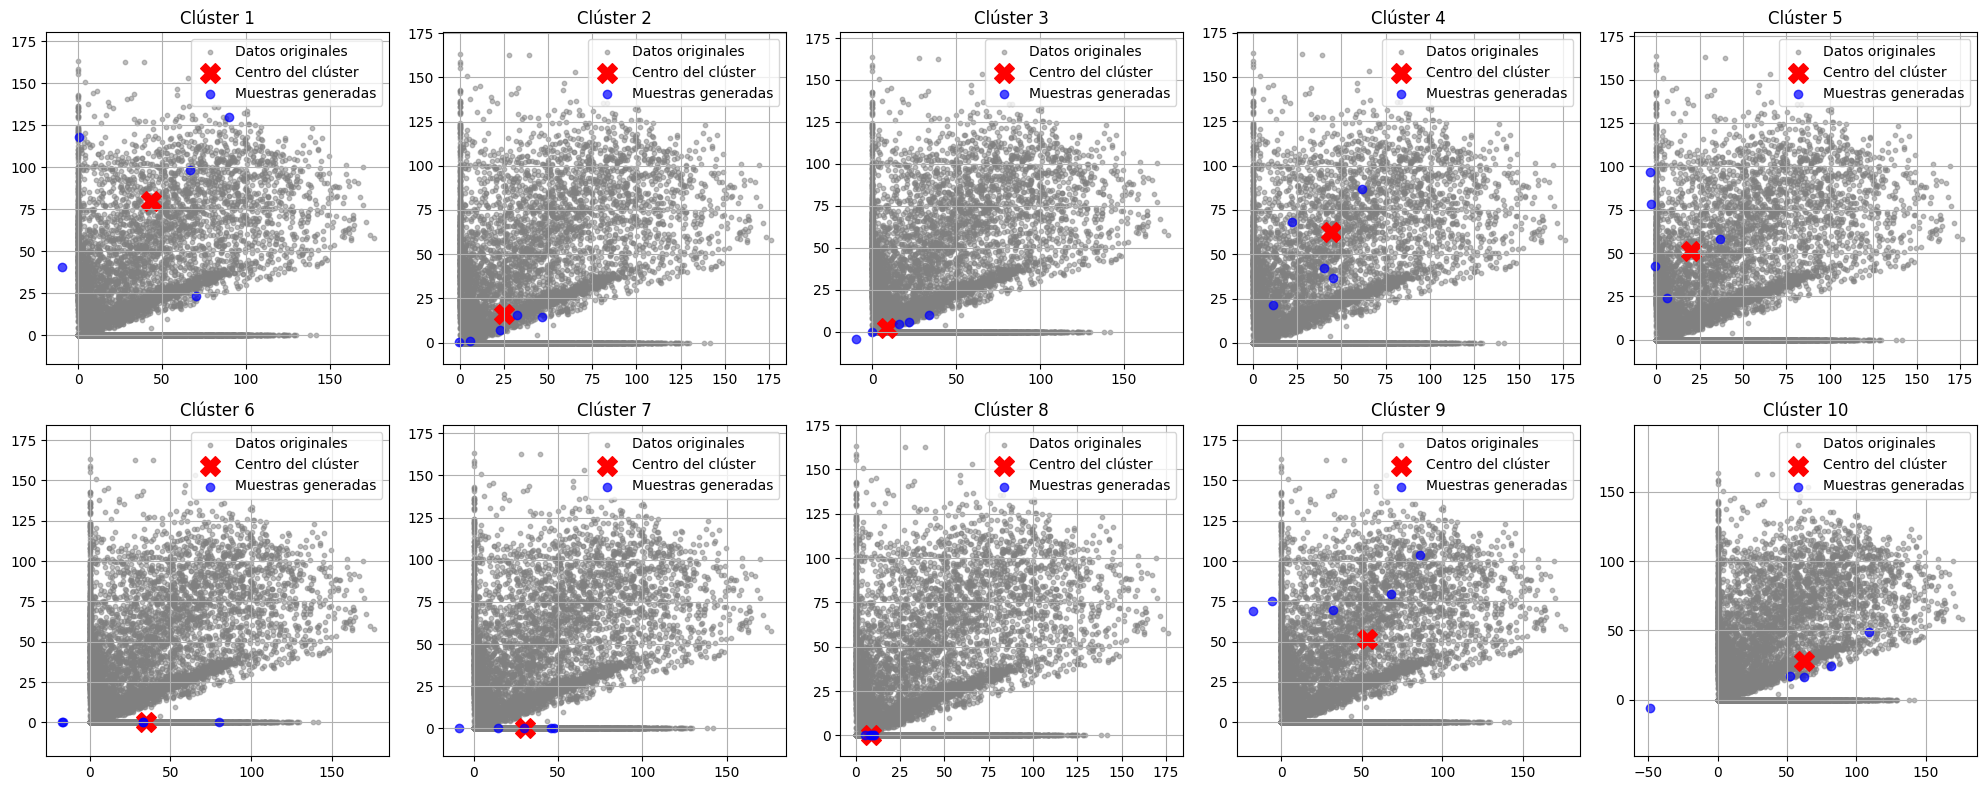

In [18]:
muestras = 5  # Cambia este número si deseas más muestras
n_clusters = 10  # Número de clústeres
all_samples = []  # Inicializar como una lista para almacenar muestras de todos los clústeres

# Crear una figura con subgráficas
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 filas y 5 columnas

# Generar muestras para cada clúster y graficarlas
for cluster in range(n_clusters):
    samples = muestras_del_cluster(cluster, muestras, medias, covarianzas)
    all_samples.append(samples)  # Agregar muestras a la lista
    
    # Seleccionar el subgráfico correspondiente
    ax = axes[cluster // 5, cluster % 5]
    
    # Graficar los datos originales
    ax.scatter(X_reducido[:, 0], X_reducido[:, 1], c='gray', alpha=0.5, label='Datos originales', s=10)

    # Graficar las medias de los clústeres
    ax.scatter(medias[cluster, 0], medias[cluster, 1], c='red', marker='X', s=200, label='Centro del clúster')

    # Graficar las muestras generadas
    ax.scatter(samples[:, 0], samples[:, 1], c='blue', alpha=0.7, label='Muestras generadas')
    
    # Configurar el título y etiquetas
    ax.set_title(f'Clúster {cluster + 1}')
    ax.legend()
    ax.grid()
    ax.axis('equal')  # Para mantener la proporción

# Ajustar el espacio entre subgráficas
plt.tight_layout()
plt.show()

Vemos que en todos los casos, excepto en el segundo y el décimo, las muestras generadas están cerca del centro del cluster.  Así que hace buenas predicciones. 

# Parte 3: Comparación PCA/Autoencoder en base a samples

Analiza visualmente dos samples de cada clase (toma dos samples de cada clase, decodifica, des-estandariza y grafica como mostramos en la parte de datos)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=23)

# Estándarizando X_sample
sc = StandardScaler()
X_std = sc.fit_transform(X_sample)

In [20]:
# Definición del autoencoder
num_dimensiones = X_std.shape[1]
encoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[num_dimensiones]),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(num_dimensiones, input_shape=[5]),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=0.1))

# Entrenar el autoencoder
history = autoencoder.fit(X_std, X_std, epochs=100, validation_data=(X_std, X_std),
                          callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/100


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9472 - val_loss: 0.6415
Epoch 2/100


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6180 - val_loss: 0.5560
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5345 - val_loss: 0.5084
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5034 - val_loss: 0.4951
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4946 - val_loss: 0.4926
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4858 - val_loss: 0.4916
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5058 - val_loss: 0.4911
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4964 - val_loss: 0.4907
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4920 - val_loss: 0.4905
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4996 - val_loss: 0.4903
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4989 - val_loss: 0.4902
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4875 - val_loss: 0.4901
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

In [21]:
clases = np.unique(y_sample)  # Obtener las clases únicas
samples_per_class = 2  # Número de muestras por clase
selected_indices = []

for clase in clases:
    # Obtener los índices de las muestras de la clase actual
    indices_clase = np.where(y_sample == clase)[0]
    # Seleccionar dos muestras aleatorias
    selected = np.random.choice(indices_clase, size=samples_per_class, replace=False)
    selected_indices.extend(selected)


In [22]:
# Convertir a array
selected_indices = np.array(selected_indices)

# Obtener las muestras seleccionadas y estandarizarlas
imagenes_seleccionadas = X_std[selected_indices]

# Codificar las imágenes seleccionadas
X_encoded = encoder.predict(imagenes_seleccionadas)

# Decodificar las imágenes seleccionadas
X_decoded = decoder.predict(X_encoded)

# Des-estandarizar las imágenes decodificadas
imagenes_decodificadas = sc.inverse_transform(X_decoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


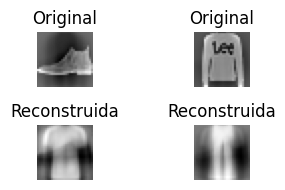

In [23]:
# Visualizar las muestras originales y reconstruidas
n_samples = 2 # Número de muestras a visualizar
plt.figure(figsize=(4, 2))

for i in range(n_samples):
    # Muestra original
    ax = plt.subplot(2, n_samples, i + 1)
    plt.imshow(X_std[i].reshape(28, 28), cmap="gray")  # Ajusta el reshape según tus datos
    plt.title("Original")
    plt.axis("off")

    # Muestra reconstruida
    ax = plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(X_decoded[i].reshape(28, 28), cmap="gray")  # Ajusta el reshape según tus datos
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()

Analiza visualmente la media

In [43]:
gmm = GaussianMixture(n_components=10, random_state=69)
gmm.fit(X_reducido)

GaussianMixture(n_components=10, random_state=69)

In [44]:
clusters = gmm.predict(X_reducido)

df = pd.DataFrame(X_reducido)
df['cluster'] = clusters

# Calcular la media de cada clúster
cluster_means = df.groupby('cluster').mean()

cluster_means.iloc[:, -2:] = np.nan

print(cluster_means)

                 0          1          2   3   4
cluster                                         
0        44.468456  80.174026  15.192779 NaN NaN
1        25.141571  16.159674   9.216226 NaN NaN
2         9.235638   2.176066   5.327368 NaN NaN
3        43.886673  62.735416   0.000000 NaN NaN
4        20.245241  51.717880  14.383852 NaN NaN
5        35.015457   0.000000   0.000001 NaN NaN
6        29.816032   0.000000  13.152861 NaN NaN
7         8.611246   0.000000   3.003850 NaN NaN
8        53.040173  51.947979  18.327602 NaN NaN
9        61.874817  27.626648   4.469131 NaN NaN


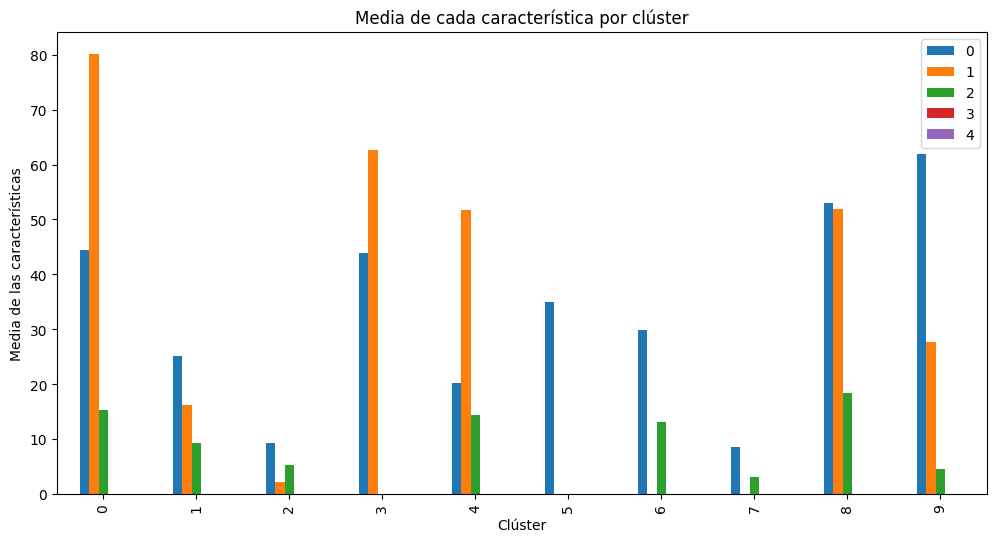

In [31]:
cluster_means.plot(kind='bar', figsize=(12, 6))
plt.title('Media de cada característica por clúster')
plt.xlabel('Clúster')
plt.ylabel('Media de las características')
plt.show()

La media no representa todas las caracteristicas. Depende del cluster. 
Los clusters 3 y 4, tiene la mayor representación de 0 y 3 respectivamente. 

¿qué clústeres parece entregar consistentemente prendas de un tipo en específico? ¿qué prendas son?

***Respuesta:*** El cluster 1, 3 y 4 parece dar la caracteristica 1 constantemente. El resto parece dar constantemente 0. 

(-0.5, 27.5, 27.5, -0.5)

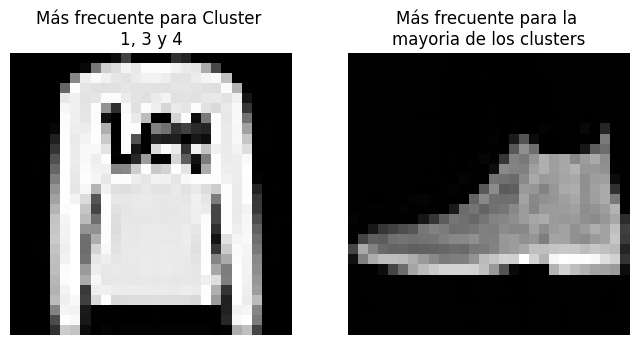

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(imagenes_desestandarizadas[1].reshape(28, 28), cmap='gray')
axs[0].set_title('Más frecuente para Cluster \n1, 3 y 4')
axs[0].axis('off')  # Opcional: oculta los ejes

axs[1].imshow(imagenes_desestandarizadas[0].reshape(28, 28), cmap='gray')
axs[1].set_title('Más frecuente para la \nmayoria de los clusters')
axs[1].axis('off')  # Opcional: oculta los ejes

Los más frecuentes son zapatos y poleras. 

Entrena un clasificador de randomforest con los datos originales. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=420)

# Crear el clasificador Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=420)

# Entrenar el clasificador
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=420)

In [40]:
# Predecir en el conjunto de prueba
y_pred = rf_clf.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del clasificador Random Forest: {accuracy:.2f}')

# Reporte de clasificación
print(classification_report(y_test, y_pred))

Precisión del clasificador Random Forest: 0.85
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       202
           1       0.98      0.95      0.97       195
           2       0.75      0.71      0.72       224
           3       0.81      0.87      0.84       197
           4       0.74      0.80      0.77       212
           5       0.97      0.94      0.95       192
           6       0.64      0.60      0.62       178
           7       0.91      0.94      0.92       201
           8       0.92      0.97      0.95       188
           9       0.94      0.93      0.94       211

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



Samplea y decodifica 50 ejemplos de cada cluster identificado por GMM, y entrégaselos al randomforest. Ahora ve los resultados de las predicciones. Vé si son consistentes en el sentido de que predicen que una buena cantidad de los ejemplos de los dos clústeres que identificaste son de una prenda en particular. 

In [45]:
gmm = GaussianMixture(n_components=2, random_state=42)  # Cambia n_components según el número de clústeres que desees
gmm.fit(X_reducido)

# Predecir los clústeres
clusters = gmm.predict(X_reducido)

In [47]:
sampled_data = []
sampled_labels = []

for cluster_id in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    sampled_indices = np.random.choice(cluster_indices, size=50, replace=False)
    
    sampled_data.append(X.iloc[sampled_indices])
    sampled_labels.append(y.iloc[sampled_indices])

# Concatenar los datos muestreados y las etiquetas
X_sampled = pd.concat(sampled_data)
y_sampled = pd.concat(sampled_labels)

In [48]:
# Dividir los datos muestreados en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

# Crear el clasificador Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el clasificador
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
y_pred = rf_clf.predict(X_test)
# Contar las predicciones
pred_counts = pd.Series(y_pred).value_counts()
print("Conteo de predicciones:")
print(pred_counts)

# Comparar con las etiquetas reales
true_counts = pd.Series(y_test).value_counts()
print("Conteo de etiquetas reales:")
print(true_counts)

Conteo de predicciones:
8    5
1    3
7    3
3    2
0    2
4    2
2    1
9    1
6    1
Name: count, dtype: int64
Conteo de etiquetas reales:
class
8    5
4    4
1    3
3    2
6    2
7    2
5    1
9    1
0    0
2    0
Name: count, dtype: int64


Vemos que en el cluster: 8, 1, 3 y 9 son contados correctamente. El resto tiene 1 número demás. 